In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

/Users/michael-tu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.optimizers import Adam, SGD

In [4]:
def load_data(path):
    return pickle.load(open(path, "rb"))

In [5]:
data_sources = ["data/viterbi_dump_k{0}_n100.pk".format(i) for i in range(1,11)]
data_sources

['data/viterbi_dump_k1_n100.pk',
 'data/viterbi_dump_k2_n100.pk',
 'data/viterbi_dump_k3_n100.pk',
 'data/viterbi_dump_k4_n100.pk',
 'data/viterbi_dump_k5_n100.pk',
 'data/viterbi_dump_k6_n100.pk',
 'data/viterbi_dump_k7_n100.pk',
 'data/viterbi_dump_k8_n100.pk',
 'data/viterbi_dump_k9_n100.pk',
 'data/viterbi_dump_k10_n100.pk']

In [6]:
# load data
data = {"d{0}".format(i+1): load_data(data_sources[i]) for i in range(0, 10)}
data.keys()

dict_keys(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10'])

In [7]:
probs = [0.1, 0.5, 0.81]

err   = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.8]

Ls    = [3, 5]

In [8]:
def show_example(data, i):
    print("Original Message:\n", data[0][i])
    print("Encoded Noisy Message:\n", data[1][i])
    print("Viterbi Decoded Message:\n", data[2][i])

In [14]:
for i in range(3):
    idx = np.random.randint(low=0, high=len(data["d5"]))
    print("idx: ", idx)
    show_example(data["d5"][(0.81, 0.05, 3)], idx)
    print("\n")

idx:  26
Original Message:
 [1. 1. 1. 0. 1.]
Encoded Noisy Message:
 [1 1 1 0 0 1 1 0 0 0 0 1 1 1]
Viterbi Decoded Message:
 [1 1 1 0 1 0 0]


idx:  36
Original Message:
 [1. 1. 1. 1. 1.]
Encoded Noisy Message:
 [1 1 1 0 0 1 0 1 0 1 0 0 1 1]
Viterbi Decoded Message:
 [1 1 1 1 1 0 0]


idx:  25
Original Message:
 [0. 1. 1. 0. 1.]
Encoded Noisy Message:
 [0 0 1 1 1 0 1 1 0 0 1 1 1 1]
Viterbi Decoded Message:
 [0 1 1 0 1 0 0]




In [15]:
def prepare_data(data, length=3, source_channels=None):
    msg, noisy_encode, viterbi_decode = list(), list(), list()
    if source_channels:
        for source in source_channels:
            if source[2] == length:
                for i in range(len(data[source][0])):
                    msg.append(data[source][0][i].astype("float64"))
                    noisy_encode.append(data[source][1][i].astype("float64"))
                    viterbi_decode.append(data[source][2][i][:len(data[source][0][i])].astype("float64"))
    else:
        for i in range(len(data[0])):
            msg.append(data[0][i].astype("float64"))
            noisy_encode.append(data[1][i].astype("float64"))
            viterbi_decode.append(data[2][i][:len(data[0][i])].astype("float64"))

    return  np.array(msg),\
            np.array(noisy_encode),\
            np.array(viterbi_decode).astype("float64")

In [16]:
msg, noisy_encode, viterbi_decode = prepare_data(data["d5"][(0.81, 0.05, 3)])

In [17]:
n = 20
print(msg[n])
print(viterbi_decode[n])

[1. 1. 1. 1. 0.]
[1. 1. 1. 1. 0.]


In [18]:
print(msg.shape)
print(noisy_encode.shape)
print(viterbi_decode.shape)

(100, 5)
(100, 14)
(100, 5)


In [19]:
def accuracy(msg, pred):
    return np.sum(msg == pred) / np.product(pred.shape)

In [20]:
accuracy(msg, viterbi_decode)

0.992

## Baseline viterbi_decoding accuracies:

In [21]:
accuracies = dict()
for k in data:
    accuracies[k] = dict()
    for source_channel in data[k]:
        msg, _, viterbi_decode = prepare_data(data[k][source_channel])
        accuracies[k][source_channel] = accuracy(msg, viterbi_decode)

In [22]:
average_accuracies_per_k = dict()
for k in accuracies:
    average_accuracies_per_k[k] = 0
    for source_channel in accuracies[k]:
        average_accuracies_per_k[k] += accuracies[k][source_channel]
    average_accuracies_per_k[k] /= len(accuracies[k].keys())

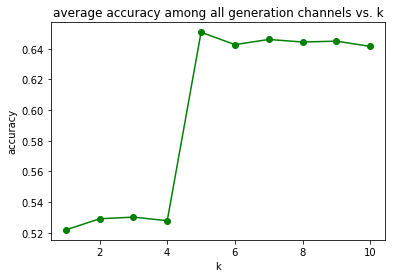

In [23]:
x = [int(x[1:]) for x in list(average_accuracies_per_k.keys())]
y = list(average_accuracies_per_k.values())

plt.title("average accuracy among all generation channels vs. k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.plot(x, y, "g-o")

# Examine Encoding Lengths (Ls)

In [24]:
# Encoding length given different source channels
for source in data["d1"].keys():
    _, x, _ = prepare_data(data["d1"][source])
    print("source {0} has encoding length:\t{1}".format(source, x.shape[1]))

source (0.1, 0.05, 3) has encoding length:	6
source (0.1, 0.05, 5) has encoding length:	10
source (0.1, 0.1, 3) has encoding length:	6
source (0.1, 0.1, 5) has encoding length:	10
source (0.1, 0.15, 3) has encoding length:	6
source (0.1, 0.15, 5) has encoding length:	10
source (0.1, 0.2, 3) has encoding length:	6
source (0.1, 0.2, 5) has encoding length:	10
source (0.1, 0.3, 3) has encoding length:	6
source (0.1, 0.3, 5) has encoding length:	10
source (0.1, 0.5, 3) has encoding length:	6
source (0.1, 0.5, 5) has encoding length:	10
source (0.1, 0.8, 3) has encoding length:	6
source (0.1, 0.8, 5) has encoding length:	10
source (0.5, 0.05, 3) has encoding length:	6
source (0.5, 0.05, 5) has encoding length:	10
source (0.5, 0.1, 3) has encoding length:	6
source (0.5, 0.1, 5) has encoding length:	10
source (0.5, 0.15, 3) has encoding length:	6
source (0.5, 0.15, 5) has encoding length:	10
source (0.5, 0.2, 3) has encoding length:	6
source (0.5, 0.2, 5) has encoding length:	10
source (0.5, 

# Model

In [25]:
def train_test_split(X, y, ratio=0.2):
    indicies = np.arange(len(X), dtype=np.int32)
    np.random.shuffle(indicies)
    
    split_inx = int(len(X) * (1-ratio))
    X_train, X_test = X[indicies[:split_inx]], X[indicies[split_inx:]]
    y_train, y_test = y[indicies[:split_inx]], y[indicies[split_inx:]]
    return X_train, X_test, y_train, y_test

In [26]:
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
data_source_num = 5
encoding_length = 3
BATCH_SIZE = 128
EPOCHS = 50
verbose = 0
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.005
optimizer = "adam" # "sgd"

In [927]:
y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                       length=encoding_length, source_channels=source_channels)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

In [935]:
architecture = [128,100,100]

In [929]:
model = Sequential()
for i, hidden in enumerate(architecture):
    if i == 0:
        model.add(Dense(hidden,  activation=ACTIVATION, input_shape=X_train.shape[1:], 
                        kernel_regularizer=regularizers.l2(l2_reg_strength)))
    else:
        model.add(Dense(hidden,  activation=ACTIVATION, 
                        kernel_regularizer=regularizers.l2(l2_reg_strength)))
        
model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
model.add(Reshape((y_train_onehot.shape[1], 2)))

In [930]:
if optimizer == "adam":
    opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
else:
    opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)
                           
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=verbose, 
              validation_split=validation_split, shuffle=True)

In [931]:
print("test accuracy:", model.evaluate(X_test, y_test_onehot)[1])

280/280 [==============================] - 0s 86us/step
test accuracy: 0.7646428550992693


In [27]:
def one_hot(data):
    res = []
    for d in data:
        res.append([0,0])
        res[-1][int(d)] = 1
    return np.array(res)

def one_hot_dataset(dataset):
    return np.array(list(map(lambda x: one_hot(x), dataset)))

def pred_to_decode(pred, threshold="argmax"):
    if type(threshold) == float:
        return np.vstack([1 if x >= threshold else 0 for x in pred])
    elif type(threshold) == str:
        if threshold == "argmax":
            return np.vstack([np.argmax(x, axis=1) for x in pred])
    else:
        return np.vstack(pred)
    
def compare_result(model, threshold=0.5):
    idx = np.random.randint(low=0, high=len(X_test)+1)
    test_x, test_y = X_test[idx:idx+1], y_test_onehot[idx]
    print("Expected: ", [np.argmax(x) for x in test_y])
    pred = model.predict(test_x)
    print("Deocde:   ", pred_to_decode(pred, threshold=threshold)[0])
    
def evaluate(X, y, model):
    y_pred = pred_to_decode(model.predict(X), threshold="argmax")
    return accuracy(y, y_pred)

In [933]:
for i in range(6):
    compare_result(model, threshold="argmax")
    print()

Expected:  [0, 1, 0, 1, 1]
Deocde:    [0 0 0 1 0]

Expected:  [1, 0, 0, 0, 1]
Deocde:    [1 0 0 0 1]

Expected:  [0, 0, 0, 0, 1]
Deocde:    [0 0 0 0 0]

Expected:  [0, 0, 0, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [0, 0, 0, 0, 1]
Deocde:    [0 0 0 0 0]

Expected:  [1, 0, 1, 0, 1]
Deocde:    [1 0 1 0 0]



In [934]:
evaluate(X_test, y_test, model)

0.7642857142857142

# Architecture Search

In [28]:
FNN_ARCHITECTURE = [
    [32, 100],
    [64, 100],
    [128, 100],
    [256, 100],
    [32, 32, 100],
    [32, 64, 100],
    [64, 64, 100],
    [64, 128, 100],
    [128, 128, 100],
    [128, 256, 100],
    [256, 256, 100],
    [32,128,128,100],
    [32,128,256,100],
    [32,256,256,100],
    [32,128,256,128,100],
    [32,128,128,128,100],
    [1024,512,100],
    [512,256,100],
    [256,128,100],
    [128,100,100]
]

In [29]:
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
data_source_num = 5
encoding_length = 3
BATCH_SIZE = 64
EPOCHS = 50
verbose = 0
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.015
optimizer = "adam" # "sgd"

In [973]:
y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                       length=encoding_length, source_channels=source_channels)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

In [30]:
def build_train_model(architecture):
    model = Sequential()
    for i, hidden in enumerate(architecture):
        if i == 0:
            model.add(Dense(hidden,  activation=ACTIVATION, input_shape=X_train.shape[1:], 
                            kernel_regularizer=regularizers.l2(l2_reg_strength)))
        else:
            model.add(Dense(hidden,  activation=ACTIVATION, 
                            kernel_regularizer=regularizers.l2(l2_reg_strength)))

    model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
    model.add(Reshape((y_train_onehot.shape[1], 2)))
    if optimizer == "adam":
        opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    else:
        opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=verbose, 
                  validation_split=validation_split, shuffle=True)
    
    return model, model.evaluate(X_test, y_test_onehot)[1]

In [976]:
models = {}
losses = {}
for architecture in FNN_ARCHITECTURE:
    name = "model-[{0}]".format(",".join([str(x) for x in architecture]))
    print("  evaluating {0}....".format(name), end="\r")
    m, l = build_train_model(architecture)
    models[name] = m
    losses[name] = l
print("done")

280/280 [==============================] - 0s 132us/step
done


In [977]:
best_model_name = list(losses.keys())[np.argmax(list(losses.values()))]
best_model = models[best_model_name]
print("best model is {0} with loss {1:.5}".format(best_model_name, losses[best_model_name]))

best model is model-[32,100] with loss 0.79464


In [979]:
losses

{'model-[1024,512,100]': 0.7596428462437221,
 'model-[128,100,100]': 0.7742857098579407,
 'model-[128,100]': 0.7803571496691023,
 'model-[128,128,100]': 0.7828571285520282,
 'model-[128,256,100]': 0.775357130595616,
 'model-[256,100]': 0.7882142867360796,
 'model-[256,128,100]': 0.7721428598676409,
 'model-[256,256,100]': 0.7700000013623919,
 'model-[32,100]': 0.7946428639548165,
 'model-[32,128,128,100]': 0.6896428499902998,
 'model-[32,128,128,128,100]': 0.6914285830089024,
 'model-[32,128,256,100]': 0.6914285830089024,
 'model-[32,128,256,128,100]': 0.6803571530750819,
 'model-[32,256,256,100]': 0.7321428520338876,
 'model-[32,32,100]': 0.7789285796029227,
 'model-[32,64,100]': 0.7824999894414629,
 'model-[512,256,100]': 0.7796428595270429,
 'model-[64,100]': 0.7882142867360796,
 'model-[64,128,100]': 0.7628571340015956,
 'model-[64,64,100]': 0.7807142853736877}

In [981]:
evaluate(X_test, y_test, best_model)

0.7964285714285714

In [984]:
for i in range(6):
    compare_result(best_model, threshold="argmax")
    print()

Expected:  [0, 0, 1, 1, 0]
Deocde:    [0 0 1 1 0]

Expected:  [0, 1, 1, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [1, 0, 1, 1, 1]
Deocde:    [0 0 0 1 1]

Expected:  [0, 0, 0, 1, 0]
Deocde:    [0 0 0 0 0]

Expected:  [0, 0, 0, 0, 0]
Deocde:    [0 0 1 1 0]

Expected:  [1, 1, 0, 1, 1]
Deocde:    [1 1 0 0 1]



In [985]:
# best_model.save("models/k5-l3-fnn-{0}.h5".format(best_model_name))

# Accuracy as a function of k

In [31]:
# encoding_length = 3
encoding_length = 3
architecture = [32,100]
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
BATCH_SIZE = 128
EPOCHS = 50
verbose = 0
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.001
optimizer = "adam" # "sgd"

In [992]:
losses = dict()
models = dict()
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

    name = "model-[{0}]-k{1}".format(",".join([str(x) for x in architecture]), data_source_num)
    print("  evaluating {0}....".format(name), end="\r")
    
    model, loss = build_train_model(architecture)
    models[name] = model
    losses[data_source_num] = loss
print("done")

280/280 [==============================] - 0s 210us/step
done


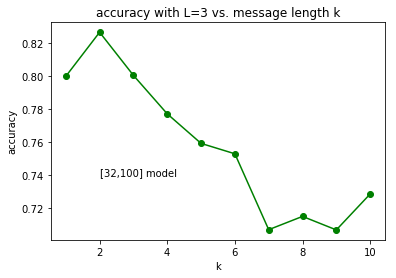

In [998]:
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=3 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "[32,100] model")
plt.plot(plt_x_axis, plt_y_axis, "g-o")

In [999]:
architecture = [32,64,100]
losses = dict()
models = dict()
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

    name = "model-[{0}]-k{1}".format(",".join([str(x) for x in architecture]), data_source_num)
    print("  evaluating {0}....".format(name), end="\r")
    
    model, loss = build_train_model(architecture)
    models[name] = model
    losses[data_source_num] = loss
print("done")

280/280 [==============================] - 0s 103us/step
done


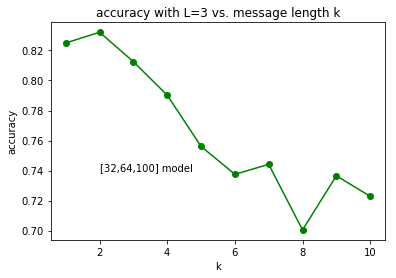

In [1000]:
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=3 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "[32,64,100] model")
plt.plot(plt_x_axis, plt_y_axis, "g-o")

280/280 [==============================] - 0s 103us/step
done


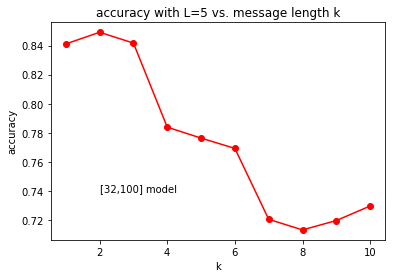

In [1001]:
encoding_length = 5
architecture = [32,100]
losses = dict()
models = dict()
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

    name = "model-[{0}]-k{1}".format(",".join([str(x) for x in architecture]), data_source_num)
    print("  evaluating {0}....".format(name), end="\r")
    
    model, loss = build_train_model(architecture)
    models[name] = model
    losses[data_source_num] = loss
print("done")
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=5 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "[32,100] model")
plt.plot(plt_x_axis, plt_y_axis, "r-o")

280/280 [==============================] - 0s 122us/step
done


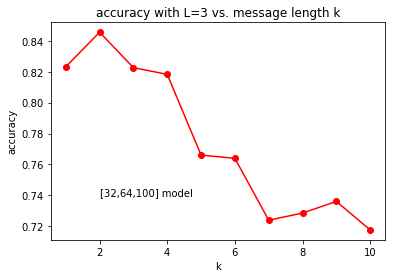

In [1002]:
encoding_length = 5
architecture = [32,64,100]
losses = dict()
models = dict()
for data_source_num in range(1,11):
    y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

    name = "model-[{0}]-k{1}".format(",".join([str(x) for x in architecture]), data_source_num)
    print("  evaluating {0}....".format(name), end="\r")
    
    model, loss = build_train_model(architecture)
    models[name] = model
    losses[data_source_num] = loss
print("done")
plt_x_axis = np.arange(start=1, stop=11)
plt_y_axis = [losses[k] for k in plt_x_axis]

plt.title("accuracy with L=3 vs. message length k")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.text(2, 0.74, "[32,64,100] model")
plt.plot(plt_x_axis, plt_y_axis, "r-o")

# CNN

In [234]:
# PARAMETERS
source_channels = [(0.1, 0.05, 3),(0.1, 0.05, 5),(0.1, 0.1, 3),
                   (0.1, 0.1, 5),(0.1, 0.15, 3),(0.1, 0.15, 5),
                   (0.1, 0.2, 3),(0.1, 0.2, 5),(0.1, 0.3, 3),
                   (0.1, 0.3, 5),(0.1, 0.5, 3),(0.1, 0.5, 5),
                   (0.1, 0.8, 3),(0.1, 0.8, 5),(0.5, 0.05, 3),
                   (0.5, 0.05, 5),(0.5, 0.1, 3),(0.5, 0.1, 5),
                   (0.5, 0.15, 3),(0.5, 0.15, 5),(0.5, 0.2, 3),
                   (0.5, 0.2, 5),(0.5, 0.3, 3),(0.5, 0.3, 5),
                   (0.5, 0.5, 3),(0.5, 0.5, 5),(0.5, 0.8, 3),(0.5, 0.8, 5)]
BATCH_SIZE = 64
EPOCHS = 30
verbose = 2
validation_split = 0.2
ACTIVATION = "relu"
l2_reg_strength = 0.001
LR = 0.01
optimizer = "adam" # "sgd"
PADDING = "same"
keep_prob = 0.5

In [165]:
data_source_num = 5

In [166]:
y, X, _ = prepare_data(data["d{0}".format(data_source_num)], 
                           length=encoding_length, source_channels=source_channels)

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_onehot, y_test_onehot = one_hot_dataset(y_train), one_hot_dataset(y_test)

In [167]:
print(X_train.shape)
print(y_train_onehot.shape)

(1120, 14)
(1120, 5, 2)


In [168]:
X_train_reshaped = X_train.reshape((-1, 2, 7))
X_test = X_test.reshape((-1, 2, 7))
print(X_train_reshaped.shape)

(1120, 2, 7)


In [266]:
model = Sequential()

model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, 
                 activation=ACTIVATION, input_shape=X_train_reshaped.shape[1:]))
model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
# model.add(MaxPooling1D(pool_size=2, padding="same"))
# model.add(AveragePooling1D(pool_size=2, padding="same"))

model.add(Conv1D(filters=16 , kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
# model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
model.add(Flatten())

model.add(Dense(200, activation=ACTIVATION))
model.add(Dropout(keep_prob))

# model.add(Dense(128, activation=ACTIVATION))
# model.add(Dropout(keep_prob))

model.add(Dense(y_train_onehot.shape[1] * 2, activation="sigmoid"))
model.add(Reshape((y_train_onehot.shape[1], 2)))

In [267]:
if optimizer == "adam":
    opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
else:
    opt = SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)
    
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=verbose, 
              validation_split=validation_split, shuffle=True)

Train on 896 samples, validate on 224 samples
Epoch 1/30
 - 3s - loss: 0.6345 - acc: 0.6778 - val_loss: 0.5974 - val_acc: 0.7071
Epoch 2/30
 - 0s - loss: 0.5803 - acc: 0.6991 - val_loss: 0.5530 - val_acc: 0.7071
Epoch 3/30
 - 0s - loss: 0.5520 - acc: 0.6993 - val_loss: 0.5429 - val_acc: 0.7071
Epoch 4/30
 - 0s - loss: 0.5389 - acc: 0.6975 - val_loss: 0.5401 - val_acc: 0.7071
Epoch 5/30
 - 0s - loss: 0.5325 - acc: 0.6983 - val_loss: 0.5470 - val_acc: 0.7076
Epoch 6/30
 - 0s - loss: 0.5271 - acc: 0.7029 - val_loss: 0.5306 - val_acc: 0.7134
Epoch 7/30
 - 0s - loss: 0.5237 - acc: 0.7081 - val_loss: 0.5364 - val_acc: 0.7161
Epoch 8/30
 - 0s - loss: 0.5197 - acc: 0.7138 - val_loss: 0.5299 - val_acc: 0.7174
Epoch 9/30
 - 0s - loss: 0.5084 - acc: 0.7148 - val_loss: 0.5293 - val_acc: 0.7147
Epoch 10/30
 - 0s - loss: 0.4961 - acc: 0.7228 - val_loss: 0.5192 - val_acc: 0.7241
Epoch 11/30
 - 0s - loss: 0.4901 - acc: 0.7267 - val_loss: 0.5190 - val_acc: 0.7165
Epoch 12/30
 - 0s - loss: 0.5022 - acc:

In [268]:
for i in range(6):
    compare_result(model, threshold="argmax")
    print()

Expected:  [1, 0, 0, 1, 0]
Deocde:    [0 0 0 0 0]

Expected:  [0, 0, 0, 1, 0]
Deocde:    [0 0 0 1 1]

Expected:  [0, 0, 1, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [1, 0, 0, 0, 0]
Deocde:    [0 0 0 1 0]

Expected:  [0, 0, 0, 0, 0]
Deocde:    [0 0 0 0 0]

Expected:  [0, 0, 0, 1, 1]
Deocde:    [0 0 0 0 0]



In [269]:
print("average test accuracy:", evaluate(X_test, y_test, model))

average test accuracy: 0.72


In [251]:
# model.save("models/k5-l3-cnn-v2.h5")